In [ ]:
import torch
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import csv
import time

In [7]:
# Helper functions
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def posemb_sincos_2d(patches, temperature=10000, dtype=torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype
    y, x = torch.meshgrid(torch.arange(h, device=device), torch.arange(w, device=device), indexing='ij')
    assert (dim % 4) == 0, 'Feature dimension must be multiple of 4 for sincos embedding'
    omega = torch.arange(dim // 4, device=device) / (dim // 4 - 1)
    omega = 1. / (temperature ** omega)
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim=1)
    return pe.type(dtype)

# FeedForward Module
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
    def forward(self, x):
        return self.net(x)

In [8]:
# Attention Module
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim=-1)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim, bias=False)

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# Transformer Module
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head),
                FeedForward(dim, mlp_dim)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

# Vision Transformer (SimpleViT)
class SimpleViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=1, dim_head=64):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_latent = nn.Identity()
        self.linear_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        *_, h, w, dtype = *img.shape, img.dtype
        x = self.to_patch_embedding(img)
        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.to_latent(x)
        return self.linear_head(x)

In [9]:
# Hyperparameters
lr = 1e-4
batch_size = 64
num_epochs = 100
patch_size = 4
image_size = 28  # MNIST image size
num_classes = 10
dim_head = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST Dataset
print("==> Preparing MNIST dataset...")
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # Grayscale normalization
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Initialize Model
print("==> Building Simple Vision Transformer model...")
net = SimpleViT(
    image_size=image_size,
    patch_size=patch_size,
    num_classes=num_classes,
    dim=dim_head,
    depth=6,
    heads=8,
    mlp_dim=512
).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

==> Preparing MNIST dataset...
==> Building Simple Vision Transformer model...


In [10]:
# 定义训练函数
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    start_time = time.time()  # 记录训练开始时间

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # 打印训练状态
        print(f"Train Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] "
              f"Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}%")

    epoch_time = time.time() - start_time  # 计算每个 epoch 的训练时间
    print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s.")
    return epoch_time, 100. * correct / total  # 返回训练时间和训练准确率

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    start_time = time.time()  # 记录推理开始时间

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    inference_time = time.time() - start_time  # 计算推理时间
    acc = 100. * correct / total
    print(f"Test Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {test_loss/len(test_loader):.4f} | Acc: {acc:.2f}% | Inference Time: {inference_time:.2f}s")
    return acc, inference_time

In [11]:
import matplotlib.pyplot as plt
# 加载检查点状态
import os
import csv

checkpoint_path = "./newsimplevit_MNIST_checkpoint1.pth"
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1  # 从下一个 epoch 开始
    print(f"Resuming from epoch {start_epoch} with best accuracy {best_acc:.2f}%")
else:
    print("No checkpoint found. Starting from scratch.")
    start_epoch = 0
    best_acc = 0

# 创建或打开 CSV 文件
csv_file = "newsimplevit_MNIST.csv"
write_header = not os.path.exists(csv_file)  # 如果文件不存在，需要写入表头

with open(csv_file, "a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["Epoch", "Train Time (s)", "Inference Time (s)", "Accuracy (%)"])

    # 开始训练
    print("==> Starting training...")
    train_times = []  # 每个 epoch 的训练时间
    inference_times = []  # 每个 epoch 的推理时间
    accuracies = []  # 每个 epoch 的测试准确率

    # 从 start_epoch 开始训练
    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # 训练
        train_time, train_acc = train(epoch)
        train_times.append(train_time)

        # 测试
        acc, inference_time = test(epoch)
        accuracies.append(acc)
        inference_times.append(inference_time)

        scheduler.step()

        # 保存最佳模型
        if acc > best_acc:
            print("Saving best model...")
            state = {
                'model': net.state_dict(),
                'optimizer': optimizer.state_dict(),  # 保存优化器状态
                'scheduler': scheduler.state_dict(),  # 保存学习率调度器状态
                'acc': acc,
                'epoch': epoch,
            }
            torch.save(state, checkpoint_path)  # 保存为检查点文件
            best_acc = acc

        # 保存当前 epoch 的记录到 CSV
        writer.writerow([epoch+1, train_time, inference_time, acc])
        f.flush()  # 确保写入文件
        print(f"Epoch {epoch+1} results saved to CSV.")

# 输出最终记录
print("\n=== Final Results ===")
print(f"Average Training Time per Epoch: {sum(train_times) / len(train_times):.2f}s")
print(f"Average Inference Time: {sum(inference_times) / len(inference_times):.2f}s")
print(f"Best Accuracy: {best_acc:.2f}%")

No checkpoint found. Starting from scratch.
==> Starting training...
Epoch 1/100
Train Epoch [1/100] Batch [1/938] Loss: 2.4610 | Acc: 9.38%
Train Epoch [1/100] Batch [2/938] Loss: 2.5006 | Acc: 9.38%
Train Epoch [1/100] Batch [3/938] Loss: 2.3329 | Acc: 9.38%
Train Epoch [1/100] Batch [4/938] Loss: 2.3542 | Acc: 9.77%
Train Epoch [1/100] Batch [5/938] Loss: 2.3281 | Acc: 9.38%
Train Epoch [1/100] Batch [6/938] Loss: 2.3994 | Acc: 9.38%
Train Epoch [1/100] Batch [7/938] Loss: 2.3708 | Acc: 9.82%
Train Epoch [1/100] Batch [8/938] Loss: 2.2802 | Acc: 9.96%
Train Epoch [1/100] Batch [9/938] Loss: 2.3571 | Acc: 9.90%
Train Epoch [1/100] Batch [10/938] Loss: 2.2823 | Acc: 10.00%
Train Epoch [1/100] Batch [11/938] Loss: 2.3173 | Acc: 10.51%
Train Epoch [1/100] Batch [12/938] Loss: 2.3174 | Acc: 10.16%
Train Epoch [1/100] Batch [13/938] Loss: 2.3143 | Acc: 10.22%
Train Epoch [1/100] Batch [14/938] Loss: 2.3230 | Acc: 9.82%
Train Epoch [1/100] Batch [15/938] Loss: 2.3334 | Acc: 9.58%
Train Epo

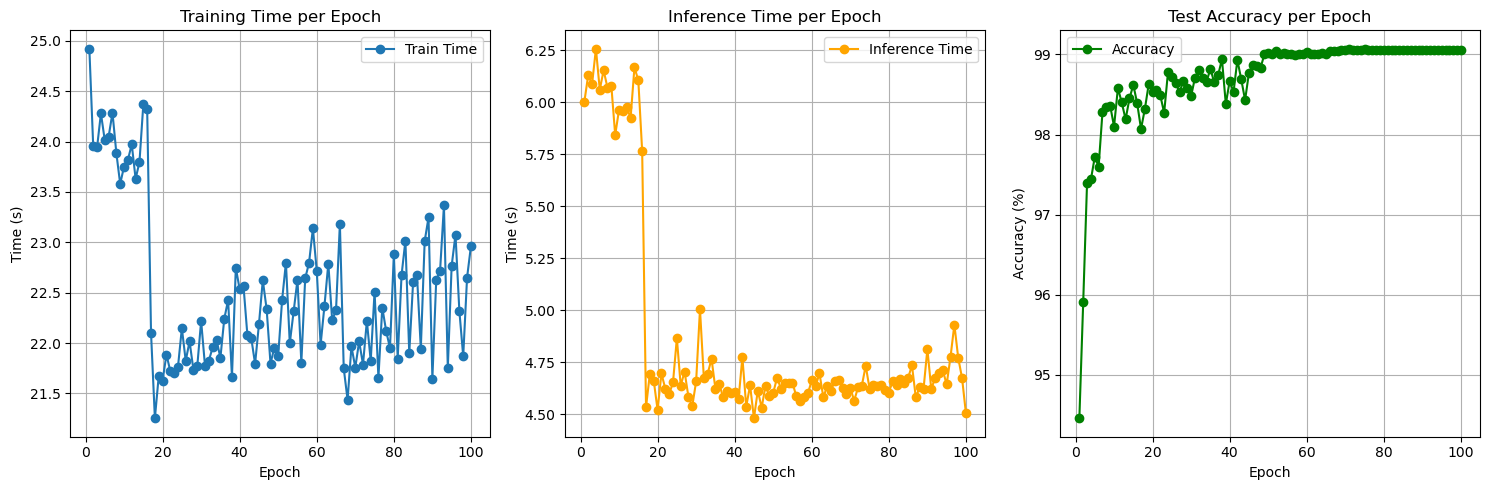

In [12]:
epochs = range(1, len(train_times) + 1) # 根据实际记录长度动态生成 x 轴
plt.figure(figsize=(15, 5))

# 训练时间趋势图
plt.subplot(1, 3, 1)
plt.plot(epochs, train_times, marker='o', label='Train Time')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Training Time per Epoch")
plt.grid(True)
plt.legend()

# 推理时间趋势图
plt.subplot(1, 3, 2)
plt.plot(epochs, inference_times, marker='o', color='orange', label='Inference Time')
plt.xlabel("Epoch")
plt.ylabel("Time (s)")
plt.title("Inference Time per Epoch")
plt.grid(True)
plt.legend()

# 分类准确率趋势图
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracies, marker='o', color='green', label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("newsimplevit_MNIST.png") # 保存可视化结果
plt.show()